# Evaluating the performance of moving average crossing algorithms 

### Author: [Lucas das Dores](https://www.linkedin.com/in/lucas-das-dores/)

In this notbook I'll analyse the performance of moving average crossing trading algorithms on cryptoassets. I have used the time series of 3.5 years of real exchange rates between Bitcoin (BTC) and USDT (a criptocurrency that has constant exchange rate 1 USDT = 1 USD) obtained from the crypotasset broker Binance.

The algorithms we are going to analyse are rather simple and only use the moving average of the exchange rates as parameters to decide whether to buy or sell a cryptoasset (in our case Bitcoin). We will see that such simple algorithms are very prone to overfit our data when used in high frequency trading and therefore are not very reliable as trading strategies in this setting. The algorithms depend on two parameters, which will be two positive integers. We will also see that, thanks to the overfitting tendency, we cannot find optimal parameters for a strategy. In fact, we will find some evidence that every choice of parameter yields a similar distribution of returns under simulations.

The notebook is divided in three sections:

1. Description of the algorithm and assumptions;
2. Definition of the auxiliary functions to create the dataframe of returns and plots; 
3. Use of the auxiliary functions for displaying the return dataframes and relevant plots.

## Algorithm and assumptions

For any time series $\{S_t\}_{t \in \mathbb{N}}$ we define its moving average on $p$ periods up to period $i$ as
$$
MA_p(i) = \dfrac{\sum_{j= i-p+1}^i S_j}{p}.
$$

Let $\{H_t\}, \{C_t\}$ and $\{P_t\}$ be the time series of inventory (in BTC), cash (in USDT) and price (in USDT/BTC).

Below we present the pseudo-code for the moving average crossing algorithm with parameters $f$, $s$ and start cash $C$, here `MA_f(t)` and `MA_s(t)` denote the moving averages $MA_f(t)$ and $MA_s(t)$ of the price series $P_t$:

In [1]:
# for t <- s to T do
   # Compute MA_f(t), MA_s(t), MA_f(t-1), MA_s(t-1)
   # if MA_f(t) > MA_s(t)  and MA_f(t-1) <= MA_s(t-1) then
      # if  H_{t-1} = 0 then
          # H_t = C_{t-1}/P_t; 
          # C_t = 0;
   # else if } MA_f(t) < MA_s(t)  and  MA_f(t-1) >= MA_s(t-1) then
      # if  H_{t-1} > 0 then
          # C_t = C_{t-1} + H_{t-1}*P_t;
          # H_t = 0;
   # else
      # H_t = H_{t-1};
      # C_t = C_{t-1};
# end for

Furthermore, we will assume that transactions costs are $1\%$ for both buying and selling BTC.

## Auxiliary functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date
from datetime import time
from datetime import datetime
from tqdm import tqdm

In [2]:
def clean_data(data):
    """Returns dataframe with time, date and closing price
    of USDT/BTC every 6 hours"""
    
    timestamps = [datetime.strptime(stamp[:16], '%Y-%m-%d %H:%M')
                  for stamp in data['timestamp']]
            
    data['timestamp'] = timestamps
    
    start_time = time(5,59,0)
    start_tstamp = datetime.combine(data['timestamp'].iloc[0].date(), start_time)
    end_tstamp = data['timestamp'].iloc[-1]
    
    selected_timestamps = pd.date_range(start = start_tstamp ,
                                        end = end_tstamp,
                                        freq = '6H').to_series()
    
    
    
    data = data[data['timestamp'].isin(selected_timestamps)]
    data = data[['timestamp', 'close']]
    data.reset_index(inplace=True, drop=True)

    return(data)

def train_test_split(data, split_time):
    """Splits data using data until the given date
    as training data and after the given date as 
    test data."""
    train_data = data[data['timestamp'] < split_time]
    test_data = data[data['timestamp'] >= split_time]
    
    train_data.reset_index(inplace=True, drop=True)
    test_data.reset_index(inplace=True, drop=True)

    return(train_data,test_data)

In [3]:
# Define moving average

def mov_avg(series, p, i):
    """Returns moving average of a series with p steps up to index i"""
    if i < p-1:
        raise Exception("Moving average undefined: Parameter i is smaller than p-1.")
    return series[i-p+1: i+1].mean() # Notice this does not include index i+1 in the sum!

In [4]:
# Define strategy algorithm with parameters f, s and C = 10000

def MACrossing(price_series, f,s, cash=10000):
    """Returns results of using the Moving Average crossing strategy with
    parameters f and s
    Returns:
        value_list: list of cash + assets position
        n_trades: number of trades executed in the series
    """
    H = 0
    C = cash
    value_list = [C for i in range(s)] # Wait for s periods
    n_trades = 0
    
    for t in price_series.index[s:]:
        ma_ft = mov_avg(price_series,f, t)
        ma_st = mov_avg(price_series, s, t)
        ma_ft_lag = mov_avg(price_series, f, t-1)
        ma_st_lag = mov_avg(price_series, s, t-1)
        
        if ma_ft > ma_st and ma_ft_lag <= ma_st_lag:
            if H == 0:
                H = C/(price_series[t] * 1.001) # buying with 0.1% operational cost
                C = 0
                n_trades += 1
                
        elif ma_ft < ma_st and ma_ft_lag >= ma_st_lag:
            if H > 0:
                C += H * price_series[t] * 0.999 # selling with 0.1% operational cost
                H = 0
        value_list.append(C + H*price_series[t])
        
    return(value_list, n_trades)

In [5]:
# Define function to create dataframe with total value
# each each day using the strategies

def get_total_value(df, param):
    """Input:
    df: Dataframe with dates and closing prices of the asset
    param: list of tuples (f,s)
              
    Returns:
    
    value_df: Dataframe with values at each date using MA Crossing 
                with all possible parameter combinations with f<s
                ranging in param
    n_trades_series: Series with number of trades executed in strategy
                       with parameters (f,s)         
    """
    
    n_trades_list = []
    valid_parameters =[]
    
    loop = tqdm(total=len(param), position = 0, leave=False)
    
    value_df = pd.DataFrame(data = df['timestamp'], columns = ['timestamp'])
    for k,(f,s) in enumerate(param):
        loop.update(1)
        loop.set_description("Executing algorithms".format(k))
        if f < s:
            value_df[(f,s)],T = MACrossing(df['close'], f, s, 10000)
            valid_parameters.append((f,s))
            n_trades_list.append(T)
        
    n_trades_series = pd.Series(n_trades_list, index= valid_parameters)
    
    return(value_df, n_trades_series)

In [6]:
# Define functions to create a monthly close dataframe from
# dataframe of dates and prices

def get_months(datetime_series):
    """Returns list of months and years in a list or series of dates"""
    month_year_list = []

    for date in datetime_series:
        month_year =(date.month, date.year)
        if month_year not in month_year_list:
            month_year_list.append(month_year)
    return(month_year_list)

def get_monthly_close(df):
    """Returns series with monthly close from a
    dataframe df with 'close' and 'timestamp' parameters
    """
    month_year_list = get_months(df['timestamp'])
    
    monthly_close_df = pd.DataFrame()
    monthly_close_df['month'] = month_year_list
    for parameters in df.columns[1:]:
        # initialize list of closing prices for a month
        monthly_close = []
        for (month,year) in month_year_list:
            
            # identify entries with given year and month
            month_entries = df['timestamp'].where([(dt.year == year and dt.month == month) for dt in df['timestamp']])
            
            # identify index of the last entry of the month
            index = df['timestamp'][df['timestamp'] == month_entries].index[-1]
            
            # define series of closing prices
            close_series = df[parameters]
            
            # add close price at the last day of the month
            monthly_close.append(close_series.loc[index]) 
        monthly_close_df[parameters] = monthly_close
    
    return(monthly_close_df)

In [7]:
def get_monthly_returns(close_df):
    """Returns dataframe with returns from
    a dataframe with closing prices and dates"""
    monthly_returns_df = pd.DataFrame(data= [f'{year}-{month}'
                                             for (month,year) in close_df['month']],
                                   columns= ['month'])
    for (f,s) in close_df.columns[1:]:
        monthly_returns_df[(f,s)] = (close_df[(f,s)] - close_df[(f,s)].shift(1))/close_df[(f,s)].shift(1)

    return(monthly_returns_df)

In [8]:
def performance_plot(df, parameter_list, name, style):
    """Plots figure with average monthly returns (or total value) on a dataframe
    and specified columns.
    
    df: Dataframe with monthly returns or total values
    parameter_list: parameters to be plotted
    name: name of the figure to save
    style: 'r' for return, 'v' for value
    """
    cm = 1/2.54
    average = df.mean(axis=1)

    fig = plt.figure(figsize=(20*cm,18*cm))
    
    y_min_val = df.loc[:, parameter_list].min().min()
    y_max_val = df.loc[:, parameter_list].max().max()

    for parameters in parameter_list:
        # Plot returns of each parameter
        if style == 'r':
            plt.plot(df['month'],
                     df[parameters],
                     label = f'f={parameters[0]}, s={parameters[1]}'
                    )
        elif style == 'v':
            plt.plot(df[parameters],
                     label = f'f={parameters[0]}, s={parameters[1]}'
                    )
        else:
            raise Exception("Undefined style: Type 'r' for return plots and 'v' for value plots.")
        
    if style == 'r':
        plt.plot(df['month'], average, label = 'average') # plot average
        fig.legend(fontsize=10,
                   bbox_to_anchor=(0.75, 0.875)
                   )
       
        first_month = df['month'].iloc[1]
        last_month = df['month'].iloc[-1]
        two_month_intervals = [df['month'].iloc[i] for i in range(1, len(df['month'])-1, 2)] 
        
        plt.xlim(first_month,last_month)
        plt.ylim(y_min_val -0.05, y_max_val + 0.05)
        plt.xticks(two_month_intervals,
                   rotation=90,
                   fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.8)
        
    elif style == 'v':
        plt.plot(average, label = 'average') # plot average
        fig.legend(fontsize=10,
                   bbox_to_anchor=(0.325, 0.8)
                  )
        plt.yticks(fontsize=12)
        step = (len(df.index)//400) *40
        plt.xticks(np.arange(0,df.index[-1],step))
        plt.xlim(0, df.index[-1])
        plt.ylim(y_min_val -3000, y_max_val + 3000)
        plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.8)
    
    plt.savefig(name)
    plt.show()

In [9]:
def get_backtest_metrics(df,n_trades):
    """Returns dataframe with average monthly return,
    its standard deviation and number of trades executed.
    
    The order is given in descending order
    from the best average monthly return.
    """
    avg_strategy_returns = np.array(df.mean(axis=1))
    
    avg_list = []
    std_list = []
    
    for column in df.columns[1:]:
        average_monthly_returns = df[column].mean()
        std_monthly_returns = df[column].std()
        
        # Add metrics rounded to 3 decimals
        avg_list.append(round(average_monthly_returns,3))
        std_list.append(round(std_monthly_returns,3))
        
    metrics = pd.DataFrame(data = {'Avg M Return' : avg_list,
                                   'Std M Return' : std_list
                                   },
                           index = monthly_returns.columns[1:],
                            )
    metrics['N trades'] = n_trades
    
    metrics.sort_values(by = 'Avg M Return',
                        ascending=False,
                        inplace=True)
    return metrics

In [10]:
def simulate_rates(start_rate,  mean, std, num_sim):
    """Return series with num_sim simulations of USDT/BTC over 400 days.
    Plots chart with the simulations.
    Input:
        start_rate: first rate of the simulations
        mean: mean of return of exchange rate
        std: standard deviation of return of exchange rate
    Output: Series with lists of prices
    """
    fig = plt.figure(figsize=(10,10))
    rate_lists = []
    for x in range(num_sim):
            # Simulates num_sim closing prices for exchange rate of BTC/USDT
            rate = start_rate
            rate_list = [rate]
            for t in range(399):
                rate = rate * np.exp(np.random.normal(mean, std))
                rate_list.append(rate)
            rate_lists.append(pd.Series(rate_list))
            plt.plot(rate_list)
    plt.title("USDT/BTC simulation")
    plt.xlim(0,400)
    plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.8)
    plt.savefig('simulation')
    plt.show()
    
    return(rate_lists)

In [11]:
def simulate_returns(rate_simulations, parameters):
    """Returns Dataframe consisting of return rates from num_sim simulations.
    Input:
        rate_simulations: Series with lists of rates
        parameters: parameters from MA Crossing to be simulated
    Output:
        simulations: DataFrame with indexes given by parameters and
        columns 'Return', 'Trades' containing lists of total return and
        number of trades per simulation.
    """
    
    num_param = len(parameters)

    # Create dataframe whose index are the parameters
    # and whose data are two empty lists to store
    # return and number of trades of each iteration of the simulation

    simulations = pd.DataFrame(data =[([],[]) for n in range(num_param)], 
                                   index=parameters,
                                     columns = ['Return', 'Trades'])
    
    loop = tqdm(total=len(rate_simulations)*len(parameters),
                position = 0,
                leave=False)
    
    for k,rate_series in enumerate(rate_simulations):
        
        for i,(f,s) in enumerate(parameters):
            
            loop.update(1)
            loop.set_description("Executing simulations".format(k*len(parameters)+i))
            
            # Apply MA Crossing strategy to rate_list with parameters (f,s)
            value_list, trades = MACrossing(rate_series, f, s)
            # Calculate total return
            total_return = (value_list[-1] - value_list[0])/value_list[0]
            # Store each return and number of trades of each strategy
            simulations.iloc[i, 0].append(total_return)
            simulations.iloc[i, 1].append(trades)
    return(simulations)

In [12]:
def get_stats(df):
    """Returns dataframe with average return,standard deviation of return
    and average number of trades in the simulation for each parameter.
    """
    stats = pd.DataFrame(index = df.index,
                         columns = ['Avg return', 'Std return', 'Avg n trades'])

    for i in range(len(df.index)):
        stats.iloc[i, 0] = round(np.mean(df.iloc[i,0]),3)
        stats.iloc[i, 1] = round(np.std(df.iloc[i,0]),3)
        stats.iloc[i, 2] = round(np.mean(df.iloc[i,1]),3)

    return(stats)

In [13]:
def plot_hist(df, param, color, name):
    """Plots and saves histogram of returns from simulation"""
    cm = 1/2.54
    
    fig, axs = plt.subplots(int(np.ceil(len(param)/2)) , 2, figsize=(30*cm,50*cm))
    max_freqs =[]

    x_min = np.floor(min([min(lst) for lst in df['Return']]))
    # Cap x_max at 5 for better visualization
    x_max = min(np.ceil(max([max(lst) for lst in df['Return']])),5)

    for i,p in enumerate(param):
        x_coord = i//2 
        y_coord = (i+1) % 2
        f,s = p
        axis = axs[x_coord, y_coord]
        
        lst = df.loc[:, 'Return'][p]
        max_value = max(lst)
        freq, bins, patches = axis.hist(x=lst,
                                       bins=np.arange(-1, x_max, 0.1),
                                       rwidth=0.8,
                                       alpha=0.65,
                                       color = color
                                       )

        axis.set_xticks(np.arange(-1,x_max,1))
        axis.tick_params(labelsize=14)
        axis.set_xlim(x_min, x_max)
        axis.set_title(f'f={f}, s={s}', fontsize=18)
        axis.grid(axis='y', color='gray', linestyle='--', linewidth=0.8)

        max_freqs.append(freq.max())

    # Define max frequency
    maxfreq = np.max(max_freqs)
    # Define limits of the plot
    y_max = np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10

    for i in range(len(param)):
        axs[i//2, (i+1) % 2].set_ylim(0, y_max)

    plt.savefig(name)
    plt.show()

## Implementation

### Data preparation and test/training split

In [14]:
# Reading data

data = pd.read_csv("binance-BTCUSDT-1m-data.csv")

In [15]:
data = clean_data(data)
data.head()

,timestamp,close
0,2017-08-17 05:59:00,4315.32
1,2017-08-17 11:59:00,4427.30
2,2017-08-17 17:59:00,4289.24
3,2017-08-17 23:59:00,4285.08
4,2017-08-18 05:59:00,4313.56


We separate the data into train data and test data. We separate last 6 months of data for out-of-sample analysis.

In [16]:
split_time = datetime(2020,8,1,0,0,0)

train_data, test_data = train_test_split(data, split_time)

In [17]:
train_data.head()

,timestamp,close
0,2017-08-17 05:59:00,4315.32
1,2017-08-17 11:59:00,4427.30
2,2017-08-17 17:59:00,4289.24
3,2017-08-17 23:59:00,4285.08
4,2017-08-18 05:59:00,4313.56


We apply the `MACrossing(f,s)` algorithm for each $5 \le f \le 15$ and $30 \le s \le 60$.

In [18]:
param = [(f,s) for f in range(5,16) for s in range(30,61)]

value_df, n_trades = get_total_value(train_data, param)

Executing algorithms: 100%|██████████████████████████████████████████████████████████| 341/341 [16:34<00:00,  2.93s/it]

The resulting dataframe is the dataframe of our position at a given time when applying the algorithm `MACrossing(f,s)` with for all `(f,s)` above. We can visualize it as follows.

In [19]:
value_df.iloc[:, :6] .head()

,timestamp,"(5, 30)","(5, 31)","(5, 32)","(5, 33)","(5, 34)"
0,2017-08-17 05:59:00,10000.0,10000.0,10000.0,10000.0,10000.0
1,2017-08-17 11:59:00,10000.0,10000.0,10000.0,10000.0,10000.0
2,2017-08-17 17:59:00,10000.0,10000.0,10000.0,10000.0,10000.0
3,2017-08-17 23:59:00,10000.0,10000.0,10000.0,10000.0,10000.0
4,2017-08-18 05:59:00,10000.0,10000.0,10000.0,10000.0,10000.0


Next we obtain the position at the end of the month for each strategy above.

In [20]:
close_df = get_monthly_close(value_df)
close_df.iloc[:,:6].tail()

,month,"(5, 30)","(5, 31)","(5, 32)","(5, 33)","(5, 34)"
31,"(3, 2020)",29745.810077,30353.491208,32702.728946,29498.372841,28681.989137
32,"(4, 2020)",36350.703009,37093.316379,39964.189390,36048.323700,34497.576094
33,"(5, 2020)",35783.709803,36514.739994,39340.833526,35106.406471,32225.922610
34,"(6, 2020)",32062.337667,34013.605396,36606.968956,32666.799776,29986.485868
35,"(7, 2020)",38019.456632,39289.447803,42679.252039,38136.512271,35089.203062


Finally we can compute the monthly returns for each strategy from the previous dataframe.

In [21]:
monthly_returns = get_monthly_returns(close_df)
monthly_returns.iloc[:, :6].tail()

,month,"(5, 30)","(5, 31)","(5, 32)","(5, 33)","(5, 34)"
31,2020-3,-0.107509,-0.102181,-0.096560,-0.113925,-0.092921
32,2020-4,0.222044,0.222044,0.222044,0.222044,0.202761
33,2020-5,-0.015598,-0.015598,-0.015598,-0.026129,-0.065850
34,2020-6,-0.103996,-0.068497,-0.069492,-0.069492,-0.069492
35,2020-7,0.185798,0.155110,0.165878,0.167439,0.170167


### Backtesting

Let's visualize the parameters of the 10 strategies with the highest average monthly return on the train data.

In [22]:
metrics = get_backtest_metrics(monthly_returns, n_trades)
metrics.head(10)

,Avg M Return,Std M Return,N trades
"(6, 53)",0.075,0.195,60
"(6, 52)",0.073,0.199,60
"(8, 47)",0.073,0.200,56
"(6, 47)",0.071,0.202,61
"(7, 49)",0.070,0.202,59
"(9, 46)",0.070,0.202,55
"(6, 45)",0.070,0.198,63
"(7, 48)",0.070,0.201,56
"(6, 43)",0.070,0.194,65
"(6, 54)",0.070,0.183,59


We can also visualize the monthly return performance and the position of each strategy above graphically.

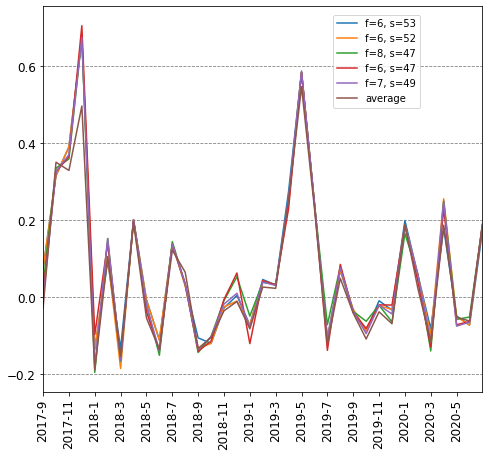

In [23]:
best_parameters = metrics.index[:5]
performance_plot(monthly_returns, best_parameters, "sample_return", 'r')

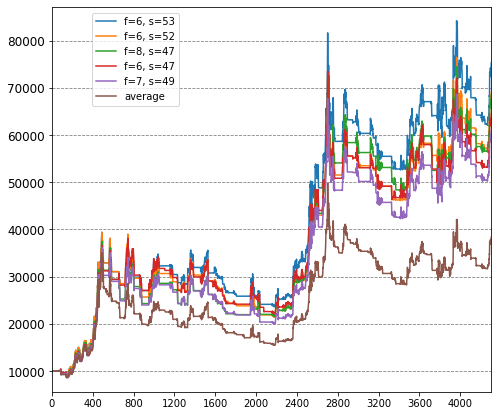

In [24]:
performance_plot(value_df, best_parameters, "sample_value", 'v')

We will perform the same analysis on the test data.

In [25]:
test_data.tail()

,timestamp,close
737,2021-02-01 11:59:00,34183.33
738,2021-02-01 17:59:00,33978.31
739,2021-02-01 23:59:00,33526.37
740,2021-02-02 05:59:00,33992.83
741,2021-02-02 11:59:00,34720.15


In [26]:
test_value, test_n_trades = get_total_value(test_data, param)
test_close = get_monthly_close(test_value)
test_returns = get_monthly_returns(test_close)

Executing algorithms: 100%|██████████████████████████████████████████████████████████| 341/341 [02:51<00:00,  1.95it/s]

We visualize the 10 strategies with highest average monthly return on the test data.

In [27]:
test_metrics = get_backtest_metrics(test_returns, test_n_trades)
test_metrics.head(10)

,Avg M Return,Std M Return,N trades
"(7, 59)",0.192,0.177,9
"(6, 60)",0.191,0.179,10
"(15, 46)",0.186,0.203,8
"(7, 60)",0.186,0.172,9
"(15, 45)",0.186,0.203,8
"(6, 57)",0.186,0.175,11
"(8, 58)",0.186,0.171,9
"(6, 59)",0.186,0.177,10
"(7, 57)",0.185,0.176,9
"(7, 58)",0.185,0.176,9


Notice that none of the strategies with best performance in terms of monthly returns on the train data are among the 10 best performers on the test data.

We can also visualize directly the performance for the 5 best parameter pairs found for the train data on the test data.

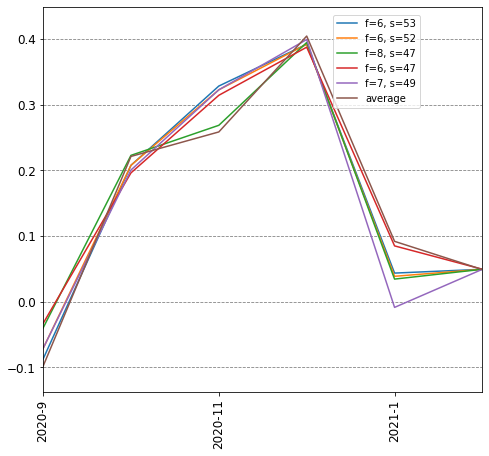

In [28]:
performance_plot(test_returns, best_parameters, "test_return", 'r')

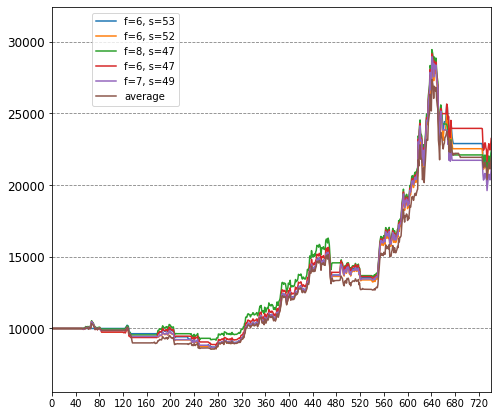

In [29]:
performance_plot(test_value, best_parameters, 'test_value', 'v')

We notice that the four among the five best parameters of the test data do not perform much better than the average in overall and monthly returns.

This is a strong indication that the best parameters found in the train data are overfitting.

We might ask ourselves if we could find parameters that performed well consistently even if the best performers overfit the data.

To do that we will perform several simulations of exchange rate and compare the distribution of performance of different `MACrossing(f,s)` strategies.

### Simulations

First, let us determine the mean and standard deviation of the return per period of 6 hours.

In [30]:
# Get historical return rates mean and standard deviation
return_rates = (data['close'] - data['close'].shift(1))/data['close'].shift(1)
mean = return_rates.mean()
std = return_rates.std()
print(mean, std)

0.0006444503956738582 0.02145722137935069


We see that the mean is very close to 0. We will assume that the mean is 0. To make the simulation simple we will assume that the (log-)return rate of the pair USDT/BTC has a normal distribution with mean 0 and standard deviation given by the historical standard deviation. In other words, if the price of 1 BTC at period $t$ is given by $P_t$ USDT, then the price of $1$ BTC at period $t+1$ is given by $P_{t+1} \times e^r$, where $r$ is a random variable with nrmal distribution with mean $0$ and standard deviation $\approx 0.021$.

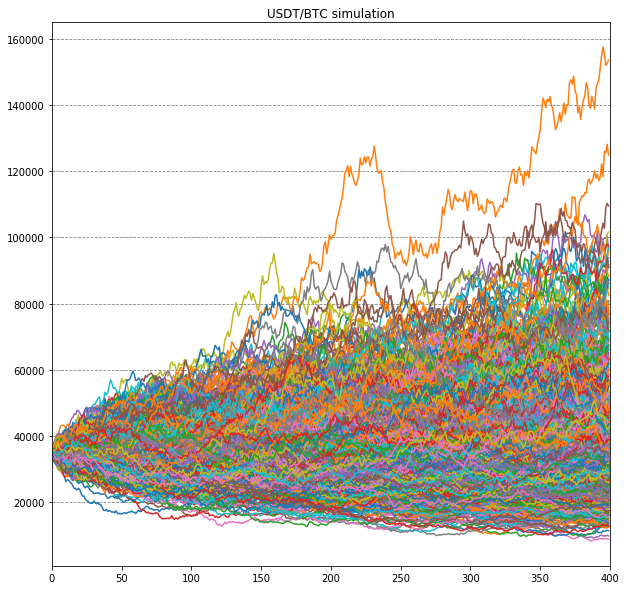

In [31]:
# Define start rate as the last rate on historical data
start_rate= data['close'].iloc[-1]

# Plot the simulations
rate_simulations = simulate_rates(start_rate, 0, std, 1000)

Next, we will select the 6 parameters with best average monthly return in the train data and the 6 with the worst average monthly return rates in the train data. We will apply the `MACrossing(f,s)` algorithm for each of the simulated rates and for each of these parameters.

In [32]:
best_param = list(metrics.index[:6])
worst_param = list(metrics.index[-6:])

param = best_param + worst_param

print('Best parameters:', best_param)
print('Worst parameters:', worst_param)

Best parameters: [(6, 53), (6, 52), (8, 47), (6, 47), (7, 49), (9, 46)]
Worst parameters: [(14, 50), (10, 32), (15, 43), (9, 33), (10, 31), (14, 38)]


In [33]:
simulation = simulate_returns(rate_simulations, param)

Executing simulations: 100%|█████████████████████████████████████████████████████| 12000/12000 [49:44<00:00,  4.02it/s]

In [34]:
# Strategies with best average returns
stats = get_stats(simulation)
#stats.sort_values(by='Avg return', ascending= False, inplace = True)
display(stats)

,Avg return,Std return,Avg n trades
"(6, 53)",0.032,0.305,5.633
"(6, 52)",0.031,0.304,5.74
"(8, 47)",0.027,0.303,5.479
"(6, 47)",0.03,0.306,6.153
"(7, 49)",0.026,0.301,5.598
"(9, 46)",0.029,0.305,5.31
"(14, 50)",0.032,0.302,4.307
"(10, 32)",0.026,0.32,6.813
"(15, 43)",0.024,0.297,4.809
"(9, 33)",0.025,0.321,6.827


From the above we see that the average return of all selected strategies in 400 periods is very close to 0 and that the standard deviation of all of them is approximately $0.3$. However from the table we don't see a clear tendency to identify if there is a best parameters performed better in general the the so called worst parameters. To give us more insight on this we plot two collections of histograms of returns, a collection of the best parameters and one of the worst parameters. So that we can visualize their approximate distributions.

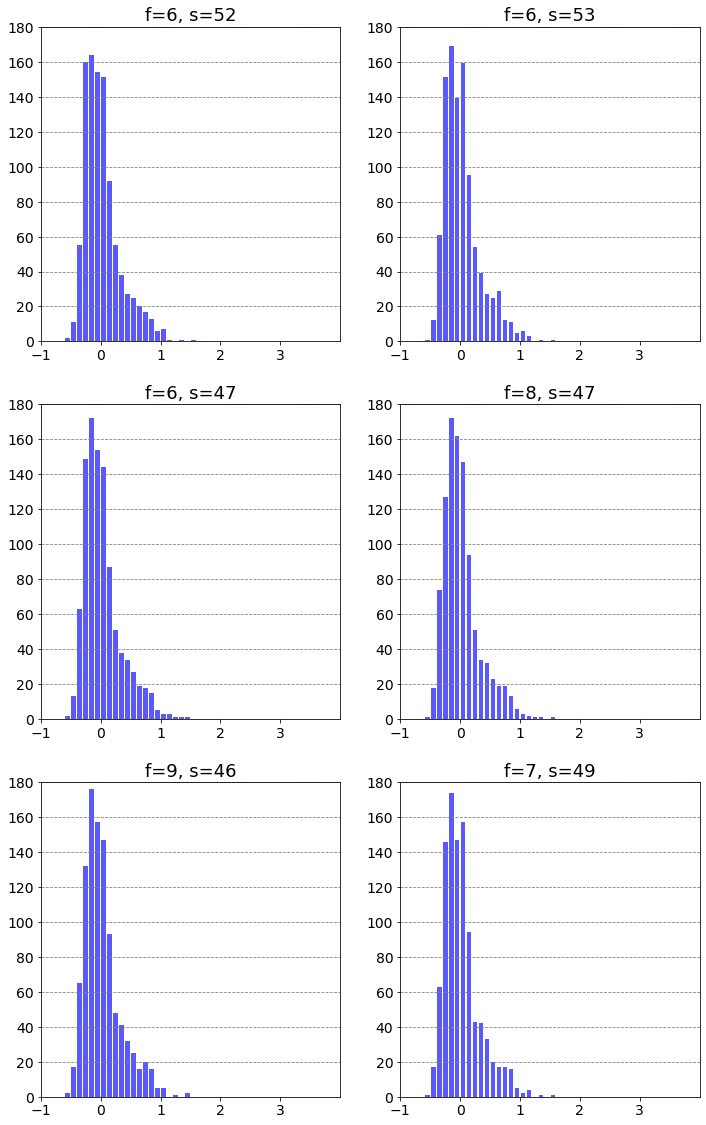

In [35]:
plot_hist(simulation, best_param[:6], 'blue', 'best_hist')

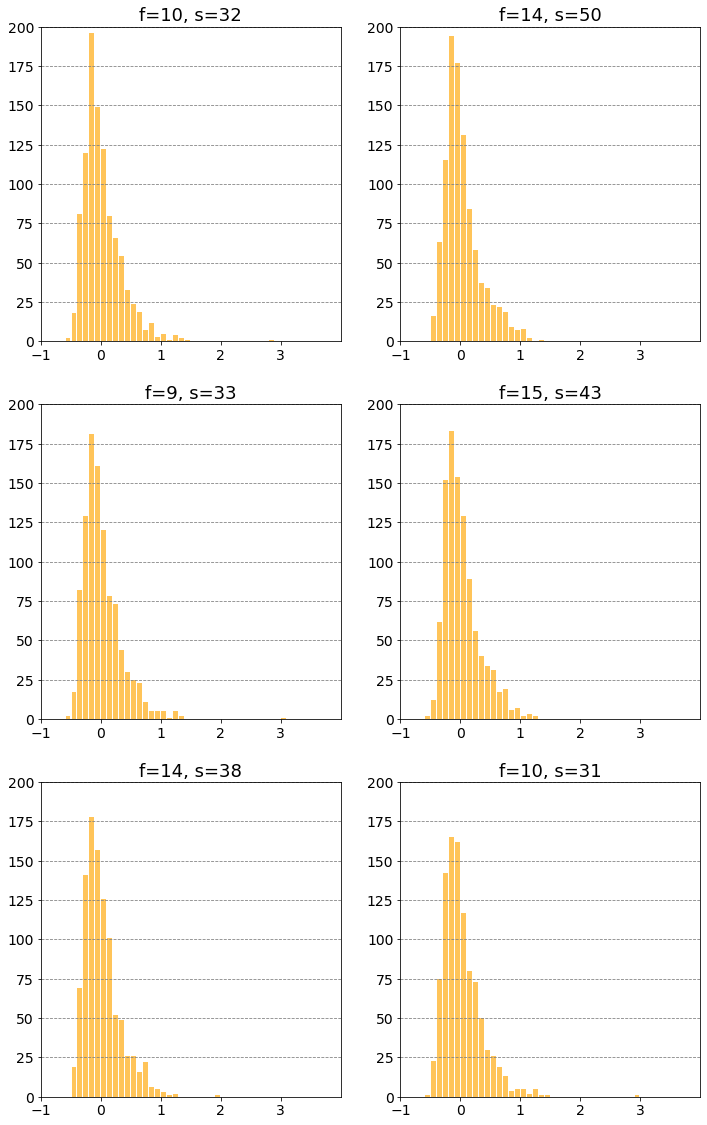

In [36]:
plot_hist(simulation, worst_param[:6], 'orange', 'worst_hist')

Notice that more than having similar mean and standard deviation, the approximate distributions of the total return for each strategy have very similar shapes even when the parameters are significantly different. Indicating that our `MACrossing(f,s)` algorithms might not have optimal parameters `(f,s)`.